Compressed image saved to compressed_image.png
Decompressed image saved to decompressed_image.png
Compression Ratio: 63.73
Mean Squared Error (MSE): 4.10


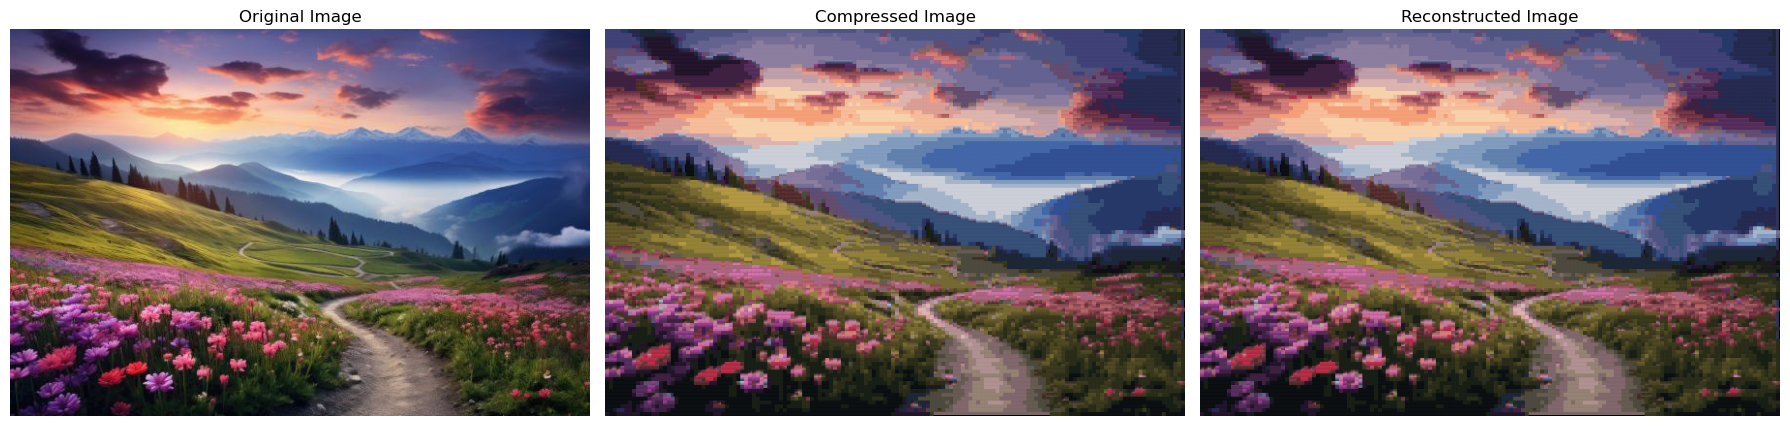

In [9]:
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

class ImageCompressor:
    def __init__(self, image_path, num_codewords=64, block_size=4):
        self.image_path = image_path
        self.num_codewords = num_codewords
        self.block_size = block_size
        self.original_img = None
        self.padded_img = None
        self.padded_shape = None
        self.codebook = None
        self.encoded_indices = None
        self.compressed_img = None

    def load_image(self):
        self.original_img = Image.open(self.image_path).convert('RGB')
        self.original_img = np.array(self.original_img)

    def pad_image(self):
        pad_height = (self.block_size - self.original_img.shape[0] % self.block_size) % self.block_size
        pad_width = (self.block_size - self.original_img.shape[1] % self.block_size) % self.block_size
        self.padded_img = np.pad(
            self.original_img, 
            ((0, pad_height), (0, pad_width), (0, 0)), 
            mode='constant', 
            constant_values=0
        )
        self.padded_shape = self.padded_img.shape

    def divide_into_blocks(self):
        return [
            self.padded_img[i:i+self.block_size, j:j+self.block_size].flatten()
            for i in range(0, self.padded_img.shape[0], self.block_size)
            for j in range(0, self.padded_img.shape[1], self.block_size)
        ]

    def create_codebook(self, image_blocks):
        kmeans = KMeans(n_clusters=self.num_codewords, random_state=42)
        kmeans.fit(image_blocks)
        self.codebook = kmeans.cluster_centers_
        return kmeans.labels_

    def encode_image(self, image_blocks):
        distances = np.linalg.norm(image_blocks[:, None] - self.codebook, axis=2)
        return np.argmin(distances, axis=1)

    def decode_image(self, encoded_indices):
        block_shape = (self.block_size, self.block_size, 3)
        reconstructed_blocks = self.codebook[encoded_indices].reshape(-1, *block_shape)
        return reconstructed_blocks

    def reconstruct_image(self, blocks):
        reconstructed_img = np.zeros(self.padded_shape, dtype=np.uint8)
        idx = 0
        for i in range(0, self.padded_shape[0], self.block_size):
            for j in range(0, self.padded_shape[1], self.block_size):
                reconstructed_img[i:i+self.block_size, j:j+self.block_size] = blocks[idx]
                idx += 1
        return reconstructed_img

    def compress(self, output_path):
        self.load_image()
        self.pad_image()
        blocks = np.array(self.divide_into_blocks())
        self.encoded_indices = self.create_codebook(blocks)
        compressed_blocks = self.codebook[self.encoded_indices].reshape(-1, self.block_size, self.block_size, 3)
        self.compressed_img = self.reconstruct_image(compressed_blocks)
        compressed_img = Image.fromarray(self.compressed_img)
        compressed_img.save(output_path)
        print(f"Compressed image saved to {output_path}")
        return output_path

    def decompress(self, output_path):
        reconstructed_blocks = self.decode_image(self.encoded_indices)
        reconstructed_img = self.reconstruct_image(reconstructed_blocks)
        reconstructed_img = Image.fromarray(reconstructed_img)
        reconstructed_img.save(output_path)
        print(f"Decompressed image saved to {output_path}")
        return output_path

    def calculate_compression_ratio(self):
        original_bits = self.original_img.shape[0] * self.original_img.shape[1] * 24
        compressed_bits = len(self.encoded_indices) * np.log2(self.num_codewords)
        return original_bits / compressed_bits

    def calculate_mse(self, reconstructed_img):
        # Crop the original image to the dimensions of the reconstructed image
        cropped_original = self.original_img[:self.padded_shape[0], :self.padded_shape[1]]
        # Remove padding from the reconstructed image
        unpadded_reconstructed = reconstructed_img[:self.original_img.shape[0], :self.original_img.shape[1]]
        return np.mean((cropped_original[:unpadded_reconstructed.shape[0], :unpadded_reconstructed.shape[1]] - unpadded_reconstructed) ** 2)/(self.block_size*self.block_size)

    def display_images(self, reconstructed_img):
        titles = ["Original Image", "Compressed Image", "Reconstructed Image"]
        images = [self.original_img, self.compressed_img, reconstructed_img]

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img)
            ax.set_title(title)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    image_path = input("Enter the path to the image: ").strip()
    compressed_path = "compressed_image.png"
    decompressed_path = "decompressed_image.png"

    compressor = ImageCompressor(image_path)
    compressed_file = compressor.compress(compressed_path)
    decompressed_file = compressor.decompress(decompressed_path)

    compressor.load_image()
    reconstructed_img = np.array(Image.open(decompressed_file))

    compression_ratio = compressor.calculate_compression_ratio()
    mse = compressor.calculate_mse(reconstructed_img)

    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")

    compressor.display_images(reconstructed_img)
